# Добавляем необходимые библиотеки:

In [3]:
pip install TensorFlow

Note: you may need to restart the kernel to use updated packages.


In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from keras import layers
import logging
import numpy as np
import PIL.Image as Image

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

CLASSIFIER_URL = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/classification/5"
IMAGE_RES = 224

# Загружаем MobileNet-модель и создаём из неё Keras-модель
model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1001)              4013897   
                                                                 
Total params: 4,013,897
Trainable params: 0
Non-trainable params: 4,013,897
_________________________________________________________________


# Генерируем обучающие и тестовую выборки:

In [7]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,     # масштабирование значений пикселей
    shear_range=0.2,    # сдвиг изображения вдоль оси X
    zoom_range=0.2,     # масштабирование изображения
    rotation_range=20,  # поворот изображения на угол в градусах
    brightness_range=[0.5, 1.5],  # изменение яркости изображения
    horizontal_flip=True, # переворот изображения относительно горизонтальной оси
    vertical_flip=True)  # переворот изображения относительно вертикальной оси  

train_set = train_datagen.flow_from_directory(
    '/kaggle/input/berserk-heroes-train',   # путь к папке с обучающими изображениями
    target_size=(IMAGE_RES, IMAGE_RES),    # размер изображений
    batch_size=32,             # размер пакета (batch)
    class_mode='categorical')       # тип меток (binary или categorical)

Found 19256 images belonging to 193 classes.


In [8]:
first_train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

first_train_set = first_train_datagen.flow_from_directory(
    '/kaggle/input/berserk-heroes-train',   # путь к папке с обучающими изображениями
    target_size=(IMAGE_RES, IMAGE_RES),    # размер изображений
    batch_size=32,             # размер пакета (batch)
    class_mode='categorical')       # тип меток (binary или categorical)

Found 19256 images belonging to 193 classes.


In [9]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_set = validation_datagen.flow_from_directory(
    '/kaggle/input/berserk-heroes-validation',
    target_size=(IMAGE_RES, IMAGE_RES),
    batch_size=32,
    class_mode='categorical')

Found 446 images belonging to 193 classes.


# Загружаем модель:

In [10]:
from math import ceil

STEPS_PER_EPOCH = ceil(len(train_set.filenames) / 128)

# Использование learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

In [11]:
fe_link = 'https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5'
feature_extractor = hub.KerasLayer(fe_link, input_shape=(IMAGE_RES, IMAGE_RES, 3))

feature_extractor.trainable = False

model = tf.keras.Sequential([
        feature_extractor,
        layers.BatchNormalization(),
        layers.Dense(193, activation='softmax'),
        layers.Dropout(0.2)
      ])

model.compile(
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1280)              2731616   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 193)               247233    
                                                                 
 dropout (Dropout)           (None, 193)               0         
                                                                 
Total params: 2,983,969
Trainable params: 249,793
Non-trainable params: 2,734,176
_________________________________________________________________


# Настраиваем обучение:

In [13]:
from keras.callbacks import EarlyStopping

early_stop =  EarlyStopping(
                              patience=10,
                              min_delta=0.001,                               
                              monitor="val_loss",
                              restore_best_weights=True
                              )


EPOCHS = 100

history = model.fit(first_train_set,
                    epochs=1,
                    validation_data=validation_set)

from tensorflow.keras.models import load_model

model.save_weights('diplom-first-run.h5')

history = model.fit(train_set,
                    epochs=EPOCHS,
                    validation_data=validation_set, 
                    callbacks=[early_stop])

602/602 [==============================] - 406s 654ms/step - loss: 3.3812 - accuracy: 0.7739 - val_loss: 2.5348 - val_accuracy: 0.5381
Epoch 1/100
602/602 [==============================] - 513s 852ms/step - loss: 3.2039 - accuracy: 0.7978 - val_loss: 1.6013 - val_accuracy: 0.6816
Epoch 2/100
602/602 [==============================] - 501s 833ms/step - loss: 3.2360 - accuracy: 0.7993 - val_loss: 1.5401 - val_accuracy: 0.7152
Epoch 3/100
602/602 [==============================] - 476s 790ms/step - loss: 3.1908 - accuracy: 0.8021 - val_loss: 1.5164 - val_accuracy: 0.7220
Epoch 4/100
602/602 [==============================] - 466s 774ms/step - loss: 3.2523 - accuracy: 0.7982 - val_loss: 1.5055 - val_accuracy: 0.7242
Epoch 5/100
602/602 [==============================] - 462s 767ms/step - loss: 3.2582 - accuracy: 0.7978 - val_loss: 1.4775 - val_accuracy: 0.7354
Epoch 6/100
602/602 [==============================] - 459s 762ms/step - loss: 3.1689 - accuracy: 0.8033 - val_loss: 1.5770 - val_

602/602 [==============================] - 406s 654ms/step - loss: 3.3812 - accuracy: 0.7739 - val_loss: 2.5348 - val_accuracy: 0.5381

Epoch 1/100
602/602 [==============================] - 513s 852ms/step - loss: 3.2039 - accuracy: 0.7978 - val_loss: 1.6013 - val_accuracy: 0.6816

Epoch 2/100
602/602 [==============================] - 501s 833ms/step - loss: 3.2360 - accuracy: 0.7993 - val_loss: 1.5401 - val_accuracy: 0.7152

Epoch 3/100
602/602 [==============================] - 476s 790ms/step - loss: 3.1908 - accuracy: 0.8021 - val_loss: 1.5164 - val_accuracy: 0.7220

Epoch 4/100
602/602 [==============================] - 466s 774ms/step - loss: 3.2523 - accuracy: 0.7982 - val_loss: 1.5055 - val_accuracy: 0.7242

Epoch 5/100
602/602 [==============================] - 462s 767ms/step - loss: 3.2582 - accuracy: 0.7978 - val_loss: 1.4775 - val_accuracy: 0.7354

Epoch 6/100
602/602 [==============================] - 459s 762ms/step - loss: 3.1689 - accuracy: 0.8033 - val_loss: 1.5770 - val_accuracy: 0.7197

Epoch 7/100
602/602 [==============================] - 457s 759ms/step - loss: 3.1458 - accuracy: 0.8048 - val_loss: 1.5475 - val_accuracy: 0.7354

Epoch 8/100
602/602 [==============================] - 460s 763ms/step - loss: 3.1876 - accuracy: 0.8022 - val_loss: 1.5620 - val_accuracy: 0.7332

Epoch 9/100
602/602 [==============================] - 462s 768ms/step - loss: 3.2512 - accuracy: 0.7983 - val_loss: 1.5295 - val_accuracy: 0.7287

Epoch 10/100
602/602 [==============================] - 454s 754ms/step - loss: 3.2212 - accuracy: 0.8001 - val_loss: 1.5592 - val_accuracy: 0.7220

Epoch 11/100
602/602 [==============================] - 460s 765ms/step - loss: 3.1190 - accuracy: 0.8065 - val_loss: 1.5764 - val_accuracy: 0.7354

Epoch 12/100
602/602 [==============================] - 471s 782ms/step - loss: 3.2746 - accuracy: 0.7968 - val_loss: 1.5735 - val_accuracy: 0.7287

Epoch 13/100
602/602 [==============================] - 459s 763ms/step - loss: 3.2662 - accuracy: 0.7974 - val_loss: 1.6502 - val_accuracy: 0.7130

Epoch 14/100
602/602 [==============================] - 470s 780ms/step - loss: 3.2197 - accuracy: 0.8002 - val_loss: 1.6507 - val_accuracy: 0.7130

Epoch 15/100
602/602 [==============================] - 457s 758ms/step - loss: 3.2393 - accuracy: 0.7988 - val_loss: 1.6233 - val_accuracy: 0.7399

In [ ]:
history = model.fit(train_set,
                    epochs=EPOCHS,
                    validation_data=validation_set, 
                    callbacks=[early_stop])

Epoch 1/100
 66/602 [==>...........................] - ETA: 6:47 - loss: 3.3122 - accuracy: 0.7945

# Сохраняем результаты:

In [14]:
history_1 = history
history_1

Epoch 1/100
602/602 [==============================] - 467s 775ms/step - loss: 3.1930 - accuracy: 0.8013 - val_loss: 1.9837 - val_accuracy: 0.6771
Epoch 2/100
602/602 [==============================] - 465s 772ms/step - loss: 3.2157 - accuracy: 0.8003 - val_loss: 1.9665 - val_accuracy: 0.6973
Epoch 3/100
602/602 [==============================] - 459s 763ms/step - loss: 3.1951 - accuracy: 0.8017 - val_loss: 1.9119 - val_accuracy: 0.6996
Epoch 4/100
602/602 [==============================] - 465s 773ms/step - loss: 3.1685 - accuracy: 0.8033 - val_loss: 1.9024 - val_accuracy: 0.6973
Epoch 5/100
602/602 [==============================] - 458s 761ms/step - loss: 3.2938 - accuracy: 0.7956 - val_loss: 1.8582 - val_accuracy: 0.7018
Epoch 6/100
602/602 [==============================] - 466s 773ms/step - loss: 3.2452 - accuracy: 0.7987 - val_loss: 1.8319 - val_accuracy: 0.7242
Epoch 7/100
602/602 [==============================] - 461s 765ms/step - loss: 3.1289 - accuracy: 0.8059 - val_loss: 1.8297 - val_accuracy: 0.7332
Epoch 8/100
602/602 [==============================] - 467s 775ms/step - loss: 3.1816 - accuracy: 0.8026 - val_loss: 1.8309 - val_accuracy: 0.7287
Epoch 9/100
602/602 [==============================] - 459s 763ms/step - loss: 3.1649 - accuracy: 0.8036 - val_loss: 1.9001 - val_accuracy: 0.7242
Epoch 10/100
602/602 [==============================] - 467s 776ms/step - loss: 3.1950 - accuracy: 0.8018 - val_loss: 1.9532 - val_accuracy: 0.7130
Epoch 11/100
602/602 [==============================] - 455s 756ms/step - loss: 3.1992 - accuracy: 0.8015 - val_loss: 1.8889 - val_accuracy: 0.7309
Epoch 12/100
602/602 [==============================] - 460s 764ms/step - loss: 3.1992 - accuracy: 0.8015 - val_loss: 1.9301 - val_accuracy: 0.7287
Epoch 13/100
602/602 [==============================] - 460s 764ms/step - loss: 3.1824 - accuracy: 0.8026 - val_loss: 1.8989 - val_accuracy: 0.7444
Epoch 14/100
602/602 [==============================] - 456s 758ms/step - loss: 3.3147 - accuracy: 0.7943 - val_loss: 2.0208 - val_accuracy: 0.7377
Epoch 15/100
602/602 [==============================] - 451s 749ms/step - loss: 3.2087 - accuracy: 0.8008 - val_loss: 2.0656 - val_accuracy: 0.7242
Epoch 16/100
602/602 [==============================] - 458s 761ms/step - loss: 3.2579 - accuracy: 0.7978 - val_loss: 2.0966 - val_accuracy: 0.7130
Epoch 17/100
602/602 [==============================] - 461s 765ms/step - loss: 3.1810 - accuracy: 0.8026 - val_loss: 2.0762 - val_accuracy: 0.7242

In [ ]:
# model.load_weights('diplom-2.h5')

# Графическое отображение результатов:

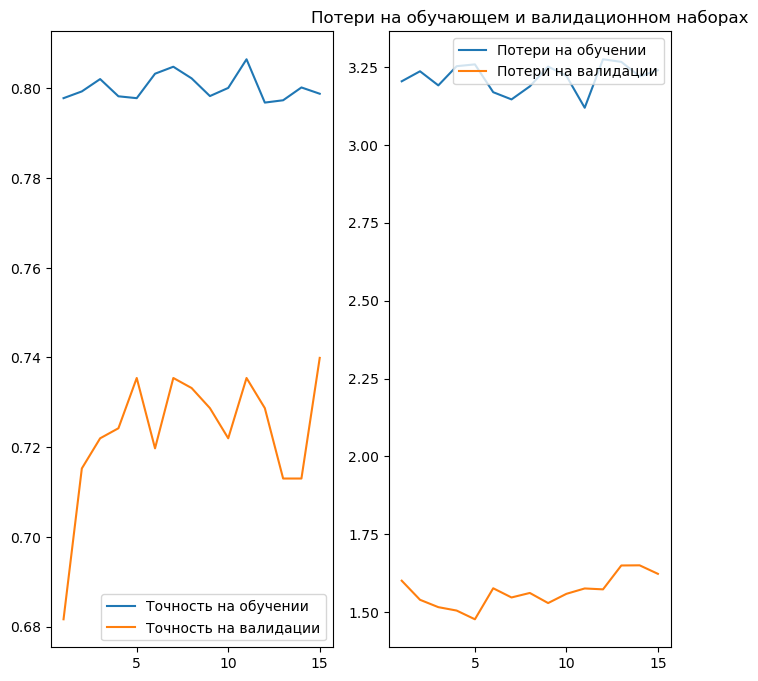

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc)+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на обучении')
plt.plot(epochs_range, val_acc, label='Точность на валидации')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на обучении')
plt.plot(epochs_range, val_loss, label='Потери на валидации')
plt.legend(loc='upper right')
plt.title('Потери на обучающем и валидационном наборах')
plt.show()

In [17]:
def data_generator(dataset, batch_size):
  i = 0
  while True:
    batch = dataset[i:i+batch_size]
    if not len(batch):
      break
    yield batch
    i += batch_size

batch_size = 10
val_data = data_generator(validation_set, batch_size)

In [18]:
class_names = np.array(list(validation_set.class_indices.keys()))

val_data = iter(validation_set)
image_batch, label_batch = next(val_data)

In [19]:
print('label_batch shape:', np.shape(label_batch))

label_batch shape: (32, 193)


In [20]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 1s 666ms/step


array(['127 - Надих', 'None', '098 - Нзами', '149 - Заказать',
       '127 - Надих', '163 - Смешались планы', '014 - Объезженный дракон',
       '123 - Камала', '161 - Серые мечники', '006 - Дракон-разведчик',
       '037 - Гном-рекрут', '063 - Дракон-страж', '067 - Кицуне',
       '084 - Финодири', '188 - Дион', '066 - Исила', '075 - Пурш',
       '057 - Уставший гном', '179 - Пани', '058 - Юный дракон',
       '082 - Тантид-мечник', '087 - Эриала', '110 - Сталкеры',
       '142 - Фальция Луна', '125 - Моровой дракон',
       '100 - Раб проклятия', '058 - Юный дракон',
       '124 - Кошмарный ловец', '120 - Децимация', '111 - Страж гробницы',
       '009 - Испытание', 'None'], dtype='<U25')

In [21]:
# преобразование матрицы предсказаний
predicted_ids = tf.one_hot(predicted_ids, 193)

In [22]:
# проверка размера матриц
print("Метки: ", label_batch.shape)
print("Предсказания: ", predicted_ids.shape)

Метки:  (32, 193)
Предсказания:  (32, 193)


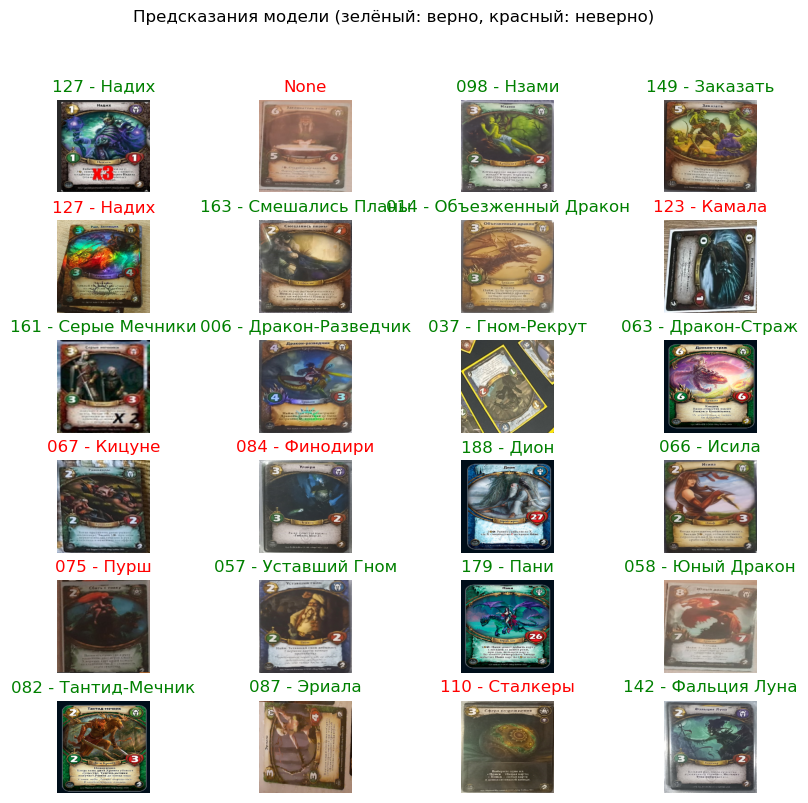

In [23]:
plt.figure(figsize=(10, 9))
for n in range(24):
  plt.subplot(6, 4, n+1)
  plt.subplots_adjust(hspace=0.3)
  plt.imshow(image_batch[n])
  color = "green" if np.array_equal(predicted_ids[n], label_batch[n]) else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Предсказания модели (зелёный: верно, красный: неверно)")